# Model Training for Sentiment Analysis

This step trains multiple machine learning models on cleaned IMDB reviews.  
We perform:
- TF-IDF vectorization of text
- Label encoding of sentiments
- Training & evaluation of Logistic Regression, Multinomial NB, and Linear SVC
- Confusion matrix and ROC curve visualization
- Saving trained models for future use

In [1]:
# Data manipulation
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

# Evaluation metrics
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve
)

# For saving models
import joblib

In [2]:
# Load cleaned dataset
df = pd.read_csv("../Data/processed_data/cleaned_reviews.csv")

In [3]:
# Preview a few rows
print(df.loc[34567:34572])

                                            cleaned_text sentiment
34567  definitely worst columbo ever dreamt murder ab...  negative
34568  title like know expect great horror movie real...  negative
34569  dont spend much time watching made tv movie se...  negative
34570  far richer texture character even classic geor...  positive
34571  film called adventure cinemascope like screenw...  negative
34572  premise movie simple script elderly muslim get...  positive


## Initial Observation

- Each row contains `cleaned_text` and `sentiment`.
- We will predict sentiment labels ('positive' / 'negative') using ML models.
- TF-IDF vectorization will convert text to numeric features.

In [4]:
# Features (text) and target (sentiment)
x = df['cleaned_text']
y = df['sentiment']

In [5]:
# Split dataset into training and testing sets (80-20)
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.2, random_state=42
)

In [6]:
# Initialize TF-IDF vectorizer
tfidf = TfidfVectorizer(
    max_features=5000,   # Use top 5000 features
    ngram_range=(1,2)    # Use unigrams and bigrams
)

# Fit on training data and transform both train & test
x_train_tfidf = tfidf.fit_transform(xtrain)
x_test_tfidf = tfidf.transform(xtest)

# Print shapes to confirm
print(x_train_tfidf.shape)
print(x_test_tfidf.shape)

(40000, 5000)
(10000, 5000)


In [8]:
# Encode sentiment labels into numeric values
lb = LabelEncoder()
y_train_lb = lb.fit_transform(ytrain)
y_test_lb = lb.transform(ytest)

In [9]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Multinomial NB': MultinomialNB(),
    'Linear SVC': LinearSVC()
}

In [10]:
# Train and evaluate each model
for model_name, model in models.items():
    print(model_name, ":")
    
    # Train model on training data
    train_model = model.fit(x_train_tfidf, y_train_lb)
    
    # Print training and test scores
    print(f"Train Score: {train_model.score(x_train_tfidf, y_train_lb)}")
    print(f"Test Score: {train_model.score(x_test_tfidf, y_test_lb)}")
    
    # Predict on test set
    pred = train_model.predict(x_test_tfidf)
    
    # Confusion matrix and accuracy
    print(f'Confusion Matrix:\n{confusion_matrix(y_test_lb, pred)}')
    print(f'Accuracy Score: {accuracy_score(y_test_lb, pred)}')
    print("-------------------------")

Logistic Regression :
Train Score: 0.9113
Test Score: 0.8883
Confusion Matrix:
[[4339  622]
 [ 495 4544]]
Accuracy Score: 0.8883
-------------------------
Multinomial NB :
Train Score: 0.866875
Test Score: 0.8557
Confusion Matrix:
[[4176  785]
 [ 658 4381]]
Accuracy Score: 0.8557
-------------------------
Linear SVC :
Train Score: 0.93015
Test Score: 0.8819
Confusion Matrix:
[[4334  627]
 [ 554 4485]]
Accuracy Score: 0.8819
-------------------------


## Model Evaluation

- Logistic Regression achieved highest accuracy on test set (~88.8%).
- Multinomial NB and Linear SVC performed slightly lower.
- Therefore, we choose Logistic Regression as our final model for deployment.

In [11]:
# Initialize and train final Logistic Regression
logistic = LogisticRegression(max_iter=1000)
logistic_model = logistic.fit(x_train_tfidf, y_train_lb)

In [12]:
# Evaluate model
print(f"Train Score: {logistic_model.score(x_train_tfidf, y_train_lb)}")
print(f"Test Score: {logistic_model.score(x_test_tfidf, y_test_lb)}")

Train Score: 0.9113
Test Score: 0.8883


In [13]:
# Predictions on test set
logistic_pred = logistic_model.predict(x_test_tfidf)

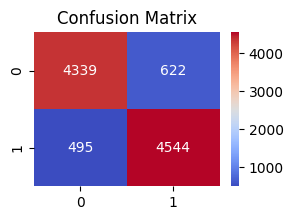

In [14]:
# Compute confusion matrix
cm_log = confusion_matrix(y_test_lb, logistic_pred)

# Plot heatmap
plt.figure(figsize=(3, 2))                    
sns.heatmap(cm_log, annot=True, cmap='coolwarm', fmt='g')
plt.title("Confusion Matrix")
plt.show()

### Model Evaluation: Confusion Matrix

The confusion matrix provides a detailed breakdown of the model's classification performance on the test set.

* **True Positives (TP):** **4,544** instances were correctly predicted as Class 1.
* **True Negatives (TN):** **4,339** instances were correctly predicted as Class 0.
* **False Positives (FP):** **622** instances were incorrectly predicted as Class 1 (Type I Error).
* **False Negatives (FN):** **495** instances were incorrectly predicted as Class 0 (Type II Error).

**Overall Insight:**
The model shows high diagonal values, indicating strong predictive accuracy for both classes. The relatively low numbers of false positives and false negatives suggest the classifier is well-balanced and performing effectively on this dataset.

In [15]:
# Print detailed classification report
print(f'Classification Report:\n{classification_report(y_test_lb, logistic_pred)}')

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



### **Model Performance: Classification Report**

The classification report provides key metrics to evaluate how well the model distinguishes between Positive (1) and Negative (0) sentiments.

* **Precision (0.88 - 0.90):** The model has a high accuracy when it predicts a specific class, with minimal "false alarms" for both positive and negative sentiments.
* **Recall (0.87 - 0.90):** The model is successful at capturing the vast majority of actual positive and negative reviews from the dataset.
* **F1-Score (0.89):** The balance between Precision and Recall is excellent, showing consistent performance across both classes.
* **Overall Accuracy (89%):** Out of 10,000 test samples, the model correctly classified 8,900 reviews.

**Conclusion:** With a weighted average of **0.89** across all metrics, the model is highly reliable and generalizes well to new, unseen movie reviews.

In [16]:
# Print overall accuracy
print(f'Accuracy Score: {accuracy_score(y_test_lb, logistic_pred)}')

Accuracy Score: 0.8883


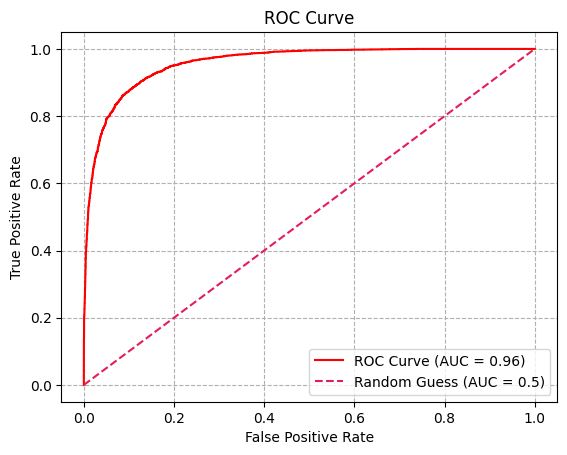

In [17]:
# Predict probabilities for ROC
log_pred_proba = logistic_model.predict_proba(x_test_tfidf)[:, 1]

# Compute ROC metrics
fpr, tpr, _ = roc_curve(y_test_lb, log_pred_proba)
roc_auc = roc_auc_score(y_test_lb, log_pred_proba)

# Plot ROC curve
plt.plot(fpr, tpr, color='red', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color="#E41D59", linestyle="--", label='Random Guess (AUC = 0.5)')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.grid(True, linestyle="--")
plt.show()  

### **Model Evaluation: Receiver Operating Characteristic (ROC) Curve**

The ROC curve illustrates the diagnostic ability of the binary classifier by plotting the True Positive Rate (Sensitivity) against the False Positive Rate (1 - Specificity).

* **AUC Score (0.96):** The Area Under the Curve is **0.96**, indicating that the model has an excellent ability to distinguish between Positive and Negative sentiments.
* **Curve Position:** The red line climbs rapidly toward the top-left corner, which signifies high sensitivity and low false-positive rates across various thresholds.
* **Comparison:** The model significantly outperforms the "Random Guess" baseline (dashed line, AUC = 0.50), proving its strong predictive power.

**Final Verdict:** An AUC of 0.96 confirms that the model is highly robust and effective for this sentiment classification task.

In [18]:
# Save trained Logistic Regression model
joblib.dump(logistic_model, "../Models/logistic_model.joblib")

['../Models/logistic_model.joblib']

In [19]:
# Save TF-IDF vectorizer
joblib.dump(tfidf, "../Models/tfidf_vectorizer.joblib")

['../Models/tfidf_vectorizer.joblib']

In [20]:
# Save Label Encoder
joblib.dump(lb, "../Models/label_encoder.joblib")

['../Models/label_encoder.joblib']